# 02: Geoprocessing


## imports


In [140]:
import pyogrio as ogr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap

# done
# spatial join
# buildings to tax lots
# buildings in 3d with lonboard
# dissolve tax lot by lu or by owner

# not done
# union tax lots and sidewalk to get blocks in total
# intersect to show non-building area
# calculate soft site potential based on FAR, lot size, building class

In [141]:
cb_307 = ogr.read_dataframe(
    "../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp", where="CD = 307"
)

<Axes: >

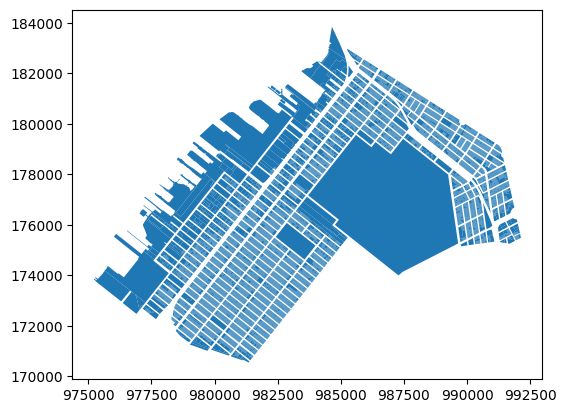

In [142]:
cb_307.plot()

In [143]:
# get maximum bounding geometry for all tax lots
bounds = cb_307.total_bounds

In [144]:
bounds_poly = gpd.GeoSeries(
    Polygon(
        [
            [bounds[0], bounds[1]],
            [bounds[0], bounds[3]],
            [bounds[2], bounds[3]],
            [bounds[2], bounds[1]],
            [bounds[0], bounds[1]],
        ]
    )
)

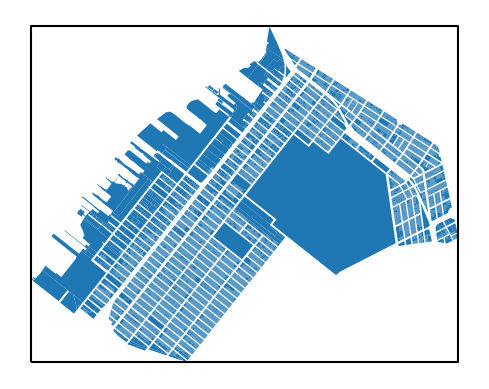

In [145]:
ax = cb_307.plot()
bounds_poly.boundary.plot(ax=ax, color="black").set_axis_off()

In [146]:
bounds_poly

0    POLYGON ((975222.902 170552.422, 975222.902 18...
dtype: geometry

In [147]:
bounds_poly.crs = cb_307.crs

In [148]:
bounds_poly.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## reproject


In [149]:
bounds_poly_wgs84 = bounds_poly.to_crs("EPSG:4326")

In [150]:
cb_307_bldgs = ogr.read_dataframe(
    "../Data/Building Footprints.geojson",
    mask=bounds_poly_wgs84[0],
)

<Axes: >

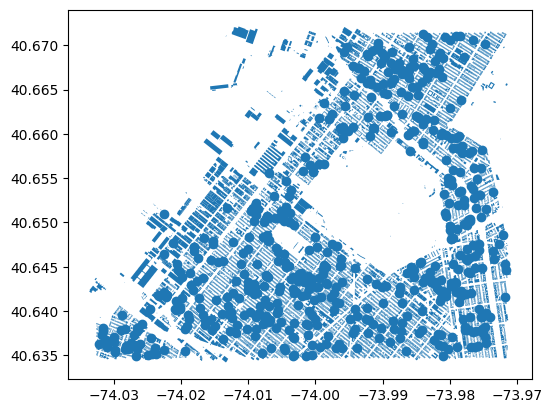

In [151]:
cb_307_bldgs.plot()

In [152]:
cb_307_bldgs = cb_307_bldgs[cb_307_bldgs.geometry.type != "Point"]

<Axes: >

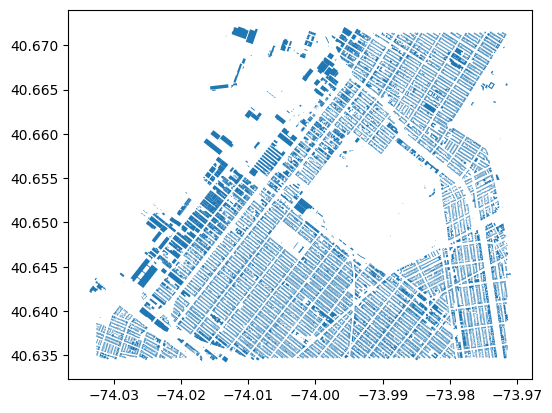

In [153]:
cb_307_bldgs.plot()

In [154]:
cb_307_bldgs = cb_307_bldgs.to_crs(cb_307.crs)

## spatial join


In [155]:
cb_307_bldgs["rep_pt"] = cb_307_bldgs.representative_point()
cb_307_bldgs.set_geometry("rep_pt", inplace=True)

In [156]:
cb_307_bldgs.base_bbl.nunique(), cb_307_bldgs.shape[0], cb_307_bldgs.globalid.nunique()

(26358, 30110, 30110)

In [157]:
cb_307_bldgs

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,globalid,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,rep_pt
0,None,3008130054,0.0,31.05,3008130054,1901,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},Constructed,2100,48,Photogramm,3014166,2017-08-22,392052,0.0,"MULTIPOLYGON (((979424.884 174653.762, 979393....",POINT (979402.531 174638.900)
1,None,3010120038,0.0,42.44,3010120038,1921,{65E24ABD-485B-4B01-B70E-5ACA0E221B53},Constructed,2100,115,Photogramm,3022371,2017-08-22,743038,0.0,"MULTIPOLYGON (((989250.122 182249.393, 989226....",POINT (989230.470 182235.219)
2,None,3053130127,0.0,26.38239517,3053130127,1940,{454D03AE-5F41-4886-A5C5-74DD122005EF},Constructed,2100,57,Photogramm,3123939,2017-08-22,785686,0.0,"MULTIPOLYGON (((989342.250 173309.206, 989328....",POINT (989345.270 173325.920)
3,None,3058710090,0.0,24.71,3058710090,1920,{F02017F9-C56E-4793-96D1-03741F2569AC},Constructed,2100,73,Photogramm,3145644,2017-08-22,560761,0.0,"MULTIPOLYGON (((976372.261 170905.430, 976404....",POINT (976382.124 170892.831)
4,None,3058850095,0.0,26.79,3058850095,1925,{D97E7A81-466F-47F7-9159-D52052EC7129},Constructed,2100,68,Photogramm,3146300,2017-08-22,541427,0.0,"MULTIPOLYGON (((975991.817 170852.230, 975985....",POINT (975969.477 170848.875)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30105,None,3055910017,0.0,60.0,3055917508,2008,{F565CBEB-73A0-4C8B-8ACF-D7E26DEDFB03},Constructed,2100,74,Other (Man,3394074,2024-05-29,1100472,0.0,"MULTIPOLYGON (((986063.897 173535.911, 986025....",POINT (986034.911 173520.284)
30106,None,3006390016,0.0,None,3006390016,2021,{019343C0-3AC3-47DE-9C68-0011F8B5B7AD},Constructed,2100,18,Other (Man,3009227,2024-05-03,1294399,0.0,"MULTIPOLYGON (((985148.458 181241.335, 985161....",POINT (985116.244 181187.492)
30107,None,3007280036,0.0,60.0,3007280036,2024,{041C01B4-5A94-46C4-A3BB-0457C706C8BC},Constructed,2100,63,Other (Man,3426350,2024-06-20,1302168,0.0,"MULTIPOLYGON (((981766.623 176163.648, 981761....",POINT (981725.644 176235.773)
30108,None,3010510039,0.0,120.0,3010510039,2023,{0007187C-0E44-4204-AFE4-F9C3FC0C1DA8},Constructed,2100,46,Other (Man,3024085,2024-06-18,1302163,0.0,"MULTIPOLYGON (((986145.791 181865.976, 986188....",POINT (986220.175 181831.511)


In [158]:
## spatial join buildings to tax lots based on building representative point
bldgs_w_lot = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin(
    cb_307, how="inner", predicate="within"
)

In [159]:
bldgs_w_lot_nearest = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin_nearest(
    cb_307, how="left", distance_col="distance"
)

<Axes: >

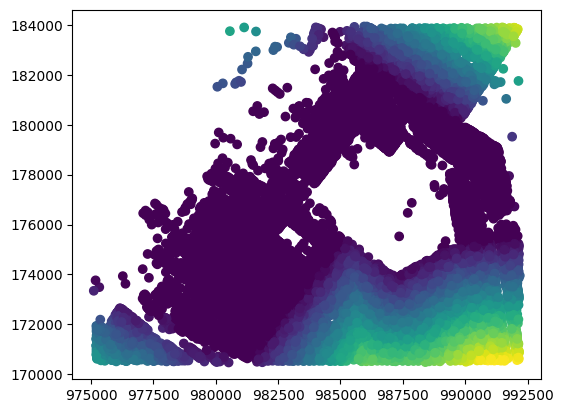

In [160]:
bldgs_w_lot_nearest.plot("distance")

<Axes: >

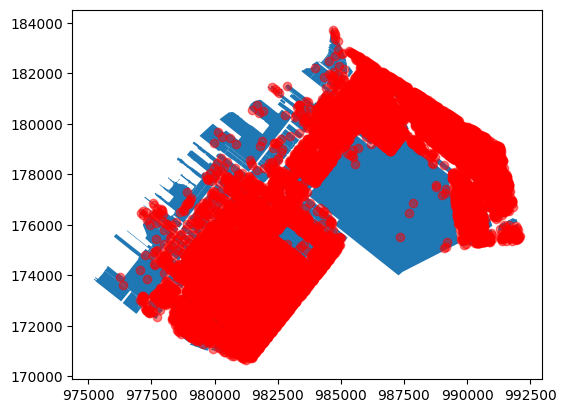

In [161]:
ax = cb_307.plot()
bldgs_w_lot.plot(ax=ax, color="red", alpha=0.5)

In [162]:
## drop cases where there is no match (i.e. no tax lot for buildings)

In [163]:
# now, join back to original building footprints
bldgs_w_lot = bldgs_w_lot.drop(columns=["rep_pt"]).merge(
    cb_307_bldgs, on="globalid", how="left"
)

In [164]:
type(bldgs_w_lot)

pandas.core.frame.DataFrame

In [165]:
bldgs_w_lot_gdf = gpd.GeoDataFrame(bldgs_w_lot, geometry="geometry")

In [166]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [167]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

<Axes: >

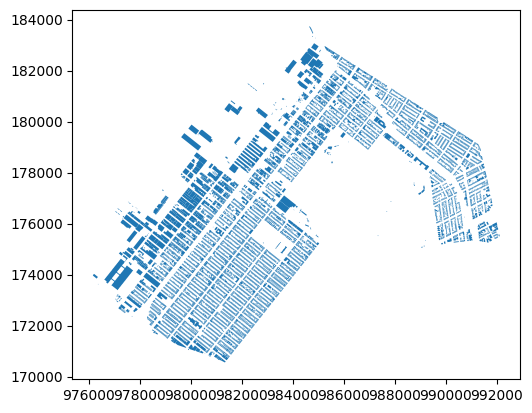

In [168]:
bldgs_w_lot_gdf.plot()

In [169]:
# now we can remap the numbers into something more meaningful

land_use_codes = {
    "01": "One & Two Family Buildings",
    "02": "Multi-Family Walk-Up Buildings",
    "03": "Multi-Family Elevator Buildings",
    "04": "Mixed Residential & Commercial Buildings",
    "05": "Commercial & Office Buildings",
    "06": "Industrial & Manufacturing",
    "07": "Transportation & Utility",
    "08": "Public Facilities & Institutions",
    "09": "Open Space & Outdoor Recreation",
    "10": "Parking Facilities",
    "11": "Vacant Land",
}

In [170]:
bldgs_w_lot_gdf["LandUse"] = bldgs_w_lot_gdf.LandUse.map(land_use_codes)

In [171]:
bldgs_w_lot_gdf["color"]= bldgs_w_lot_gdf["LandUse"].map(cmap)

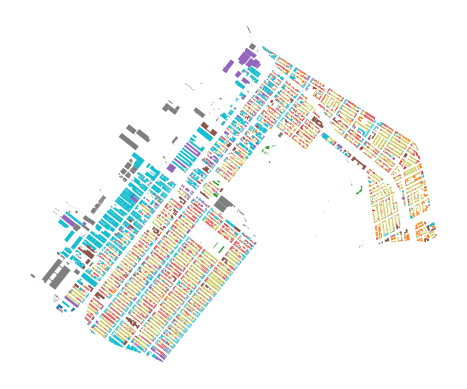

In [172]:
bldgs_w_lot_gdf.plot(column="color", legend=False).set_axis_off()

In [173]:
bldgs_w_lot_gdf.fillna({"LandUse": "Unknown"}, inplace=True)

In [174]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [175]:
bldgs_w_lot_gdf["color"]

0        #ff0000
1        #800000
2        #ffff00
3        #ff00ff
4        #ff0000
          ...   
14310    #0000ff
14311    #00ffff
14312    #800000
14313    #ff00ff
14314    #800080
Name: color, Length: 14315, dtype: object

In [176]:
# make a lonboard plot with color based on land use and height based on number of floors
heights = bldgs_w_lot_gdf["heightroof"].astype(float).to_numpy()
bldgs_layer = PolygonLayer.from_geopandas(
    bldgs_w_lot_gdf[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(bldgs_w_lot_gdf["LandUse"], cmap=cmap_rgb),
    extruded=True,
    get_elevation=heights,
)

m = Map(
    [bldgs_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

c:\Users\fauxi\anaconda3\envs\cdp\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x000002047D27F5E0>
[
…

## attribute join


... sometimes it makes more sense to join based on attributes rather than spatial relationships. This is one of those cases.


In [177]:
cb_307_bldgs.mpluto_bbl.nunique(), cb_307.shape

(26321, (13284, 95))

In [178]:
cb_307.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [179]:
cb_307_bldgs.mpluto_bbl.dtype, cb_307.BBL.dtype

(dtype('O'), dtype('float64'))

In [180]:
cb_307_bldgs.mpluto_bbl

0        3008130054
1        3010120038
2        3053130127
3        3058710090
4        3058850095
            ...    
30105    3055917508
30106    3006390016
30107    3007280036
30108    3010510039
30109    3008500069
Name: mpluto_bbl, Length: 30110, dtype: object

In [181]:
cb_307_bldgs["mpluto_bbl"] = cb_307_bldgs["mpluto_bbl"].astype(float)

In [182]:
bldgs_w_lot_attrib = cb_307_bldgs.merge(
    cb_307, left_on="mpluto_bbl", right_on="BBL", how="inner"
)

In [183]:
bldgs_w_lot_gdf

,globalid,mpluto_bbl_x,index_right,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,...,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,rep_pt,color
0,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},3008130054,10165,BK,813,54,307,3002000,30020002002,20,...,2100,48,Photogramm,3014166,2017-08-22,392052,0.0,"MULTIPOLYGON (((979424.884 174653.762, 979393....",POINT (979402.531 174638.900),#ff0000
1,{6290F624-6A8D-482F-8BD9-57C27337D89F},3008370001,6986,BK,837,1,307,3002200,30022002000,22,...,2100,36,Photogramm,3341882,2017-08-22,721766,0.0,"MULTIPOLYGON (((978615.393 174418.816, 978592....",POINT (978532.245 174359.877),#800000
2,{F68D5818-C246-4828-A454-10D28962217D},3007890064,6576,BK,789,64,307,3002000,30020001003,20,...,2100,32,Photogramm,3013180,2017-08-22,729838,0.0,"MULTIPOLYGON (((979722.511 175458.427, 979700....",POINT (979672.912 175444.400),#ffff00
3,{441DAB8C-3423-4722-ABDE-4BFE5A472C2B},3052800064,12901,BK,5280,64,307,3050001,30500011001,500,...,2100,62,Photogramm,3122680,2017-08-22,427739,0.0,"MULTIPOLYGON (((989834.116 175442.434, 989851....",POINT (989860.229 175412.619),#ff00ff
4,{B8BC6B19-B2E4-4842-8B03-5C28CC13A572},3011150070,12117,BK,1115,70,307,3017100,30171002000,171,...,2100,147,Photogramm,3027391,2017-08-22,752842,0.0,"MULTIPOLYGON (((990301.650 178978.578, 990273....",POINT (990278.753 178961.422),#ff0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14310,{EC248E59-BB81-4165-A0CF-C0CDB0689BDA},3009007505,7950,BK,900,7505,307,3014700,30147002002,147,...,2100,125,Other (Man,3428570,2023-08-04,1290485,0.0,"MULTIPOLYGON (((986516.044 179263.976, 986551....",POINT (986564.958 179261.978),#0000ff
14311,{019343C0-3AC3-47DE-9C68-0011F8B5B7AD},3006390016,4789,BK,639,16,307,3014500,30145004000,145,...,2100,18,Other (Man,3009227,2024-05-03,1294399,0.0,"MULTIPOLYGON (((985148.458 181241.335, 985161....",POINT (985116.244 181187.492),#00ffff
14312,{041C01B4-5A94-46C4-A3BB-0457C706C8BC},3007280036,9347,BK,728,36,307,3008200,30082002003,82,...,2100,63,Other (Man,3426350,2024-06-20,1302168,0.0,"MULTIPOLYGON (((981766.623 176163.648, 981761....",POINT (981725.644 176235.773),#800000
14313,{0007187C-0E44-4204-AFE4-F9C3FC0C1DA8},3010510039,3814,BK,1051,39,307,3011700,30117003002,117,...,2100,46,Other (Man,3024085,2024-06-18,1302163,0.0,"MULTIPOLYGON (((986145.791 181865.976, 986188....",POINT (986220.175 181831.511),#ff00ff


In [184]:
# assert bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape
bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape

False

<Axes: >

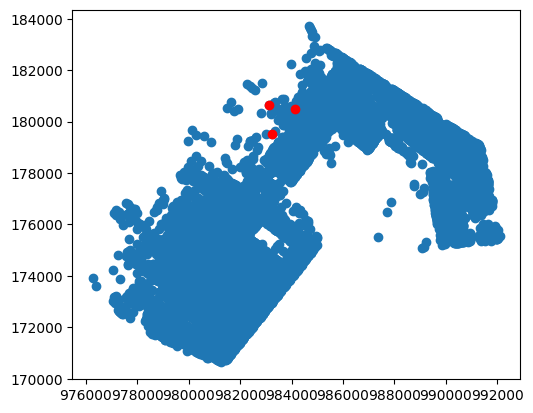

In [185]:
# find the globalid of the buildings in bldgs_w_lot_attrib that are not in bldgs_w_lot_gdf
ax = bldgs_w_lot_attrib.plot()
bldgs_w_lot_attrib[~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)].plot(
    ax=ax, color="red"
)

In [186]:
missing_buildings = bldgs_w_lot_attrib[
    ~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)
].globalid.unique()

In [187]:
bldgs_w_lot_attrib["geometry"] = bldgs_w_lot_attrib["geometry_x"]

In [188]:
bldgs_w_lot_attrib.set_geometry("geometry", inplace=True)

### investigate- what's going on??


In [191]:
# make a lonboard plot with color based on land use and height based on number of floors

missing_bldgs = bldgs_w_lot_attrib[bldgs_w_lot_attrib.globalid.isin(missing_buildings)]

heights_missing = missing_bldgs["heightroof"].astype(float).to_numpy()

lots_layer = PolygonLayer.from_geopandas(
    cb_307[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(cb_307["LandUse"], cmap=cmap_rgb),
)

missing_bldgs_layer = PolygonLayer.from_geopandas(
    missing_bldgs[["geometry", "LandUse"]],
    get_fill_color=[255, 0, 0, 155],
    extruded=True,
    get_elevation=heights_missing,
)

m = Map(
    [missing_bldgs_layer, lots_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

KeyError: '01'

So we can see that there are three cases where buildings are associated with lots, even if their representative point (or entire geometry) fall outside of the actual polygon.


## dissolve


Learn more about dissolve here: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html


In [192]:
cb_307_by_owner = cb_307.dissolve(
    by="OwnerName",
    aggfunc={
        "LandUse": list,
        "LotArea": "sum",
    },
).reset_index()

In [193]:
cb_307_by_owner

,OwnerName,geometry,LandUse,LotArea
0,*** NO OWNER FOUND ***,"POLYGON ((980590.724 174235.587, 980527.813 17...",[01],2003
1,1-10 BUSH TERMINAL OWNER LP,"POLYGON ((982202.987 178074.791, 982200.638 17...","[05, 06, 06, 05, 06, 05, 10, 06]",722097
2,10 E 4TH STREET LLC,"POLYGON ((990181.201 176930.755, 990282.152 17...",[02],2050
3,10-16 OCEAN REALTIES,"POLYGON ((991792.749 176633.932, 991787.150 17...",[03],42968
4,100 19TH STREET,"POLYGON ((989711.736 177970.244, 989649.158 17...",[02],6010
...,...,...,...,...
12136,"ZWERLING, CARA","POLYGON ((990576.588 178737.293, 990630.331 17...",[01],2000
12137,"ZWICK, ELAINE R","POLYGON ((990085.407 178976.260, 990103.152 17...",[02],2000
12138,ZWL REALTY LLC,"POLYGON ((983015.618 174308.387, 982951.592 17...",[02],2003
12139,ZY MANAGEMENT LLC,"POLYGON ((981487.360 171696.522, 981474.555 17...",[04],2017


In [194]:
cb_307_by_owner.sort_values("LotArea", ascending=False).head(10)

,OwnerName,geometry,LandUse,LotArea
5133,GREENWOOD CEMETRY,"POLYGON ((984765.258 175999.082, 984925.008 17...",[09],20309060
8473,NYC DEPARTMENT OF SMALL BUSINESS SERVICES,"MULTIPOLYGON (((977030.251 172629.699, 976946....","[07, 07, 07, 06, None, 07, 11, 07, 07, 07, 10,...",14330563
10900,UNAVAILABLE OWNER,"MULTIPOLYGON (((981243.984 170905.640, 981282....","[02, 02, 03, 02, 09, 01, 03, 02, 02, 04, 05, 0...",2145841
8471,NYC DEPARTMENT OF PARKS AND RECREATION,"MULTIPOLYGON (((978465.658 171814.400, 978466....","[09, 09, 09, 09, 09, 09, 09, 09, 09, 11, 09, 0...",1779509
2140,"ASTORIA GENERATING COMPANY ACQUISITIONS, L.L.C.","MULTIPOLYGON (((978444.216 175678.927, 978168....","[07, 07, 07]",1493713
1,1-10 BUSH TERMINAL OWNER LP,"POLYGON ((982202.987 178074.791, 982200.638 17...","[05, 06, 06, 05, 06, 05, 10, 06]",722097
8468,NYC DEPARTMENT OF EDUCATION,"MULTIPOLYGON (((978862.322 173019.035, 978673....","[08, 08, 08, 08, 08, 08, 09, 08, 08, 08, 08, 0...",717864
10051,"SIP HOLDINGS VENTURE, LLC","POLYGON ((984386.571 181329.041, 984380.016 18...","[05, 06, 11, 05, None]",528901
2141,"ASTORIA GENERATING COMPANY, L.P.","POLYGON ((983947.513 180523.148, 983958.019 18...",[07],515406
214,19-20 BUSH TERMINAL OWNER LP,"POLYGON ((981122.148 177799.108, 980997.043 17...","[06, 06, 06, 10, 06]",507505


Text(0.5, 1.0, 'Top 10 Owners by Lot Area')

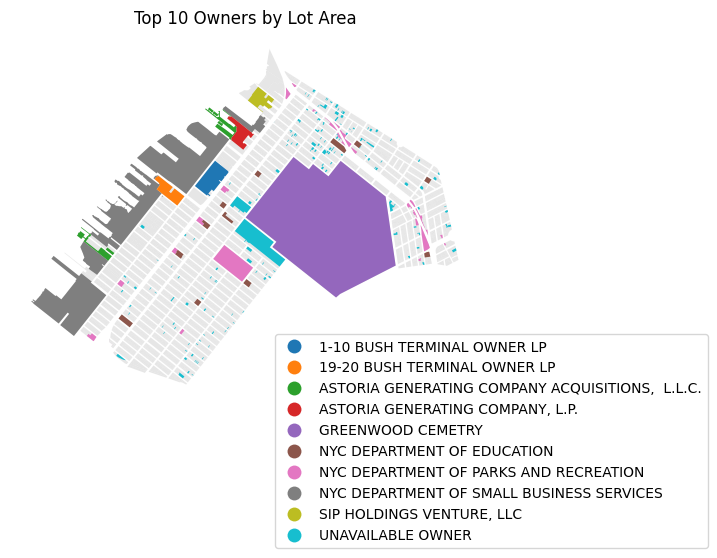

In [195]:
fig, ax = plt.subplots()
cb_307.plot(color="#cecece", ax=ax, alpha=0.5)

cb_307_by_owner.sort_values("LotArea", ascending=False).head(10).plot(
    column="OwnerName", legend=True, ax=ax
).set_axis_off()


# get legend item
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 0.0, 0.5, 0.2))
ax.set_title("Top 10 Owners by Lot Area")
# put legend off the plot
# cb_307_by_owner.plot(column="OwnerName", legend=False)

In [196]:
cb_307_by_owner

,OwnerName,geometry,LandUse,LotArea
0,*** NO OWNER FOUND ***,"POLYGON ((980590.724 174235.587, 980527.813 17...",[01],2003
1,1-10 BUSH TERMINAL OWNER LP,"POLYGON ((982202.987 178074.791, 982200.638 17...","[05, 06, 06, 05, 06, 05, 10, 06]",722097
2,10 E 4TH STREET LLC,"POLYGON ((990181.201 176930.755, 990282.152 17...",[02],2050
3,10-16 OCEAN REALTIES,"POLYGON ((991792.749 176633.932, 991787.150 17...",[03],42968
4,100 19TH STREET,"POLYGON ((989711.736 177970.244, 989649.158 17...",[02],6010
...,...,...,...,...
12136,"ZWERLING, CARA","POLYGON ((990576.588 178737.293, 990630.331 17...",[01],2000
12137,"ZWICK, ELAINE R","POLYGON ((990085.407 178976.260, 990103.152 17...",[02],2000
12138,ZWL REALTY LLC,"POLYGON ((983015.618 174308.387, 982951.592 17...",[02],2003
12139,ZY MANAGEMENT LLC,"POLYGON ((981487.360 171696.522, 981474.555 17...",[04],2017


## Intersect / Difference


In [197]:
sample_block = cb_307.Block.sample(1).values[0]

In [198]:
sample_block

655

In [199]:
cb_307_bldgs.columns

Index(['name', 'base_bbl', 'shape_area', 'heightroof', 'mpluto_bbl',
       'cnstrct_yr', 'globalid', 'lststatype', 'feat_code', 'groundelev',
       'geomsource', 'bin', 'lstmoddate', 'doitt_id', 'shape_len', 'geometry',
       'rep_pt'],
      dtype='object')

In [200]:
sample_block_lots = cb_307[cb_307.Block.eq(sample_block)].copy()
sample_block_bldgs = cb_307_bldgs[
    cb_307_bldgs.mpluto_bbl.isin(sample_block_lots.BBL.unique())
].copy()

In [201]:
sample_block_bldgs.set_geometry("geometry", inplace=True)

<Axes: >

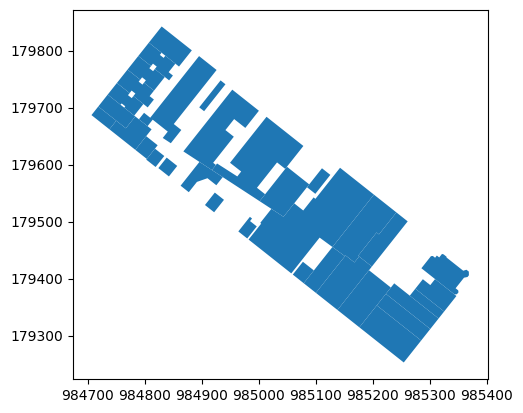

In [202]:
sample_block_bldgs.plot()

Text(0.5, 1.0, 'Block 655')

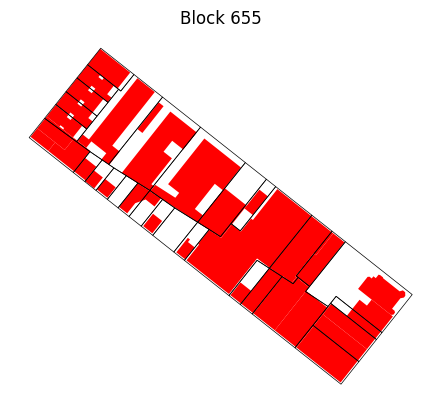

In [203]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_bldgs.plot(ax=ax, color="red").set_axis_off()

ax.set_title(f"Block {sample_block}")

In [204]:
sample_block_non_bldg = sample_block_lots.difference(sample_block_bldgs.unary_union)

In [205]:
sample_block_non_bldg.shape

(30,)

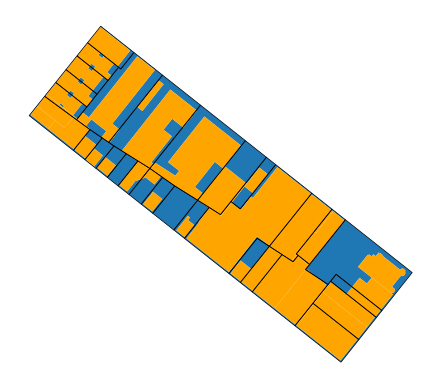

In [206]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_non_bldg.plot(ax=ax)
sample_block_bldgs.plot(ax=ax, color="orange").set_axis_off()

In [207]:
sample_block_non_bldg_intersect = sample_block_lots.intersection(
    sample_block_bldgs.unary_union
)

In [208]:
sample_block_non_bldg_intersect.shape

(30,)

<Axes: >

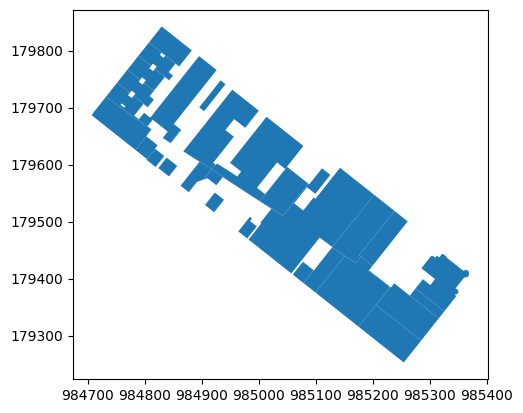

In [209]:
sample_block_non_bldg_intersect.plot()

## Union


In [210]:
sample_block_lots["lot_area"] = sample_block_lots.area

In [212]:
lots_bldgs_union = gpd.overlay(sample_block_lots, sample_block_bldgs, how="union")

C:\Users\fauxi\AppData\Local\Temp\ipykernel_9252\3882292701.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  lots_bldgs_union = gpd.overlay(sample_block_lots, sample_block_bldgs, how="union")


In [213]:
lots_bldgs_union.shape

(121, 112)

In [214]:
import pandas as pd

In [215]:
lots_bldgs_union

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,rep_pt,geometry
0,BK,655.0,1.0,307.0,3010100,30101001001,101,1001,15,38.0,...,Constructed,2100,28,Photogramm,3336869,2017-08-22,679393,0.0,POINT (984776.424 179655.792),"POLYGON ((984811.242 179660.874, 984802.471 17..."
1,BK,655.0,1.0,307.0,3010100,30101001001,101,1001,15,38.0,...,Constructed,2100,29,Photogramm,3336867,2017-08-22,315125,0.0,POINT (984751.321 179692.853),"POLYGON ((984781.810 179682.481, 984766.845 17..."
2,BK,655.0,1.0,307.0,3010100,30101001001,101,1001,15,38.0,...,Constructed,2100,29,Photogramm,3009632,2017-08-22,377186,0.0,POINT (984803.272 179630.137),"POLYGON ((984783.622 179625.698, 984783.471 17..."
3,BK,655.0,1.0,307.0,3010100,30101001001,101,1001,15,38.0,...,Constructed,2100,29,Photogramm,3336868,2017-08-22,475111,0.0,POINT (984728.274 179681.844),"POLYGON ((984738.033 179661.813, 984706.540 17..."
4,BK,655.0,3.0,307.0,3010100,30101001001,101,1001,15,38.0,...,Constructed,2100,28,Photogramm,3336869,2017-08-22,679393,0.0,POINT (984776.424 179655.792),"POLYGON ((984787.812 179678.074, 984781.810 17..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Constructed,2100,29,Photogramm,3009612,2017-08-22,784880,0.0,POINT (984822.721 179782.502),"MULTIPOLYGON (((984842.867 179747.910, 984817...."
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Constructed,2100,50,Photogramm,3396125,2017-08-22,131460,0.0,POINT (985116.657 179417.728),"MULTIPOLYGON (((985145.370 179443.488, 985145...."
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Constructed,2100,60,Photogramm,3336876,2017-08-22,491762,0.0,POINT (985316.944 179370.869),"POLYGON ((985325.311 179342.607, 985325.311 17..."
119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Constructed,2100,41,Photogramm,3336871,2017-08-22,812689,0.0,POINT (984920.911 179662.386),"MULTIPOLYGON (((984918.478 179591.222, 984918...."


<Axes: >

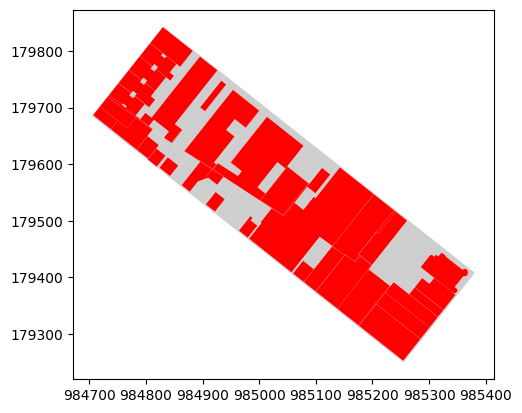

In [216]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot(color="#cecece")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot(ax=ax, color="red")

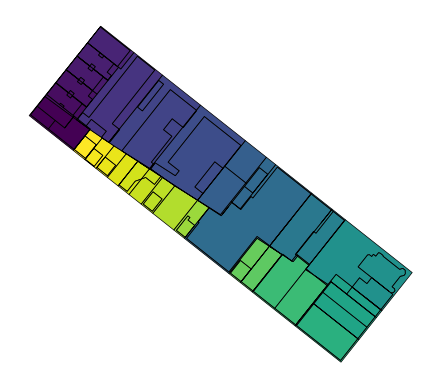

In [217]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot("Lot")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot("Lot", ax=ax)
lots_bldgs_union.boundary.plot(color="black", ax=ax, linewidth=0.5).set_axis_off()

In [218]:
lots_bldgs_union.globalid.unique()

array(['{13658D06-317B-40FE-9958-BD15EE8A8DB8}',
       '{C8E8C6AA-A4AA-4C3C-B380-6F7CC581D1B2}',
       '{CDE421E2-AA69-47AC-9C47-0745B9287479}',
       '{E564BD8D-DC54-4952-AE01-4F5644F7997F}',
       '{2BDC2E2E-DE69-40B3-ADB1-638B89B3E0BA}',
       '{24A182A2-D14A-4369-820E-64A096E01413}',
       '{2C1793A8-EB1F-4806-B0B4-0D2FAE75DA76}',
       '{B0FE6390-0599-4D3D-BB46-140152D0D9D6}',
       '{4D524B97-BDF9-477A-B1F3-989C956C324E}',
       '{148621F7-E06F-4035-95CD-DC46D3314865}',
       '{B751F172-24BF-4390-ADFE-27FDC9C78255}',
       '{DD41AE3D-E727-4E67-AE60-F6A7DB7114C7}',
       '{B351DD8F-D0AE-481D-97E2-731AD15C07AA}',
       '{FCAF0D6B-DE0D-412C-9164-71CD9A57142F}',
       '{AE38EBE8-29DC-43E6-B697-1A8BF7766EE1}',
       '{DAF0E9B2-FF91-42DA-93ED-BD83E50B617B}',
       '{19191DFA-3334-48E8-8AFE-F44B622C2644}',
       '{BA3022B6-EF0C-4F27-AF8F-BFE90F3C2A41}',
       '{CC0A5972-7D37-4E1C-86CD-E89C74EF0422}',
       '{EF42A572-2F60-4437-9578-D8D051D1237A}',
       '{625C6864-B7

In [219]:
lots_bldgs_union["pct_bldg_lot_coverage"] = lots_bldgs_union.apply(
    lambda x: ((x.geometry.area / x.lot_area) * 100 if type(x.globalid) == str else -1),
    axis=1,
)

<Axes: >

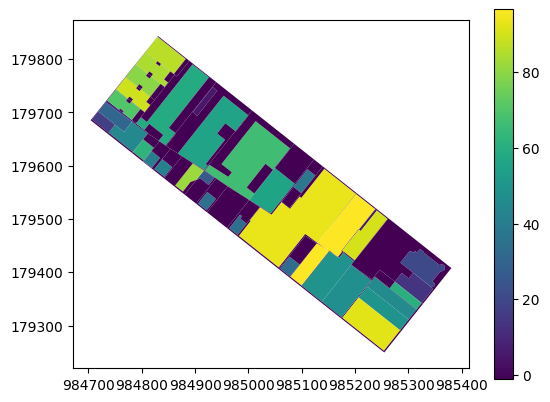

In [220]:
lots_bldgs_union.plot("pct_bldg_lot_coverage", legend=True)

## calculate soft sites (create new attributes)


In [221]:
def is_soft_site(r, threshold=0.33):
    if (
        r.BuiltFAR <= r.ResidFAR * threshold
        and r.LotArea > 10000
        and r.LandUse != "Open Space & Outdoor Recreation"
        and r.ResidFAR > 0
    ):
        return 1
    else:
        return 0

In [222]:
cb_307["soft_site"] = cb_307.apply(is_soft_site, axis=1)

In [223]:
cb_307["soft_site"].value_counts()

soft_site
0    13246
1       38
Name: count, dtype: int64

<Axes: >

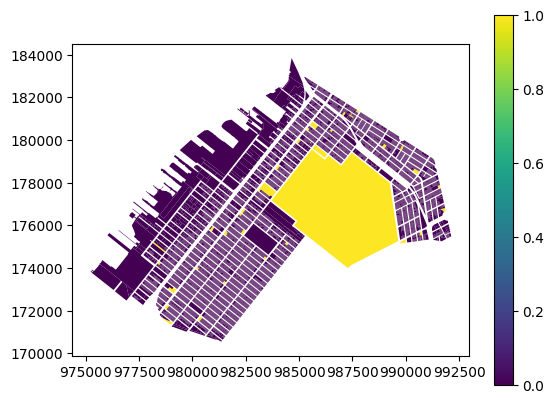

In [224]:
cb_307.plot("soft_site", legend=True)

In [225]:
cb_307[cb_307.soft_site.eq(1)][["soft_site", "BuiltFAR", "ResidFAR"]]

,soft_site,BuiltFAR,ResidFAR
157,1,0.10,2.00
490,1,0.65,4.00
491,1,0.19,4.00
641,1,0.22,4.00
995,1,0.01,2.00
2403,1,0.50,3.00
3058,1,0.00,3.00
3364,1,0.54,4.00
3687,1,0.00,2.00
3924,1,0.54,2.00
